# Employee Attrition analysis - visualisations

The four base hypotheses set for investigation are as follows:

- Hypothesis 1 - No one department has greater attrition than the others
- Hypothesis 2 - Job stagnation leads to attrition 
- Hypothesis 3 - Attrition is greater for younger employees
- Hypothesis 4 - Commute distance has an impact on retention.

As the ydata profile did not show any 1:1 correlation between attrition and employee satisfaction scores, those will not be looked at in this section. However, in the machine learning section, those will be included in the data to see if there is a more nuanced relationship when looking for patterns.

In [20]:
## Step 1 - Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats
%matplotlib inline

In [10]:
#Step 2 - import cleaned data into dataframe
df = pd.read_csv('../Data files/HR_Attrition_Cleaned.csv')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           1470 non-null   int64  
 1   Attrition                     1470 non-null   object 
 2   BusinessTravel                1470 non-null   object 
 3   DailyRate                     1470 non-null   int64  
 4   Department                    1470 non-null   object 
 5   DistanceFromHome              1470 non-null   int64  
 6   Education                     1470 non-null   object 
 7   EducationField                1470 non-null   object 
 8   EnvironmentSatisfaction       1470 non-null   object 
 9   Gender                        1470 non-null   object 
 10  HourlyRate                    1470 non-null   int64  
 11  JobInvolvement                1470 non-null   object 
 12  JobLevel                      1470 non-null   int64  
 13  Job

---

### Hypothesis 1 - no one department has greater attrition than the others.
To test this hypothesis we will look at the proportion of attrition per department rather than absolute numbers.

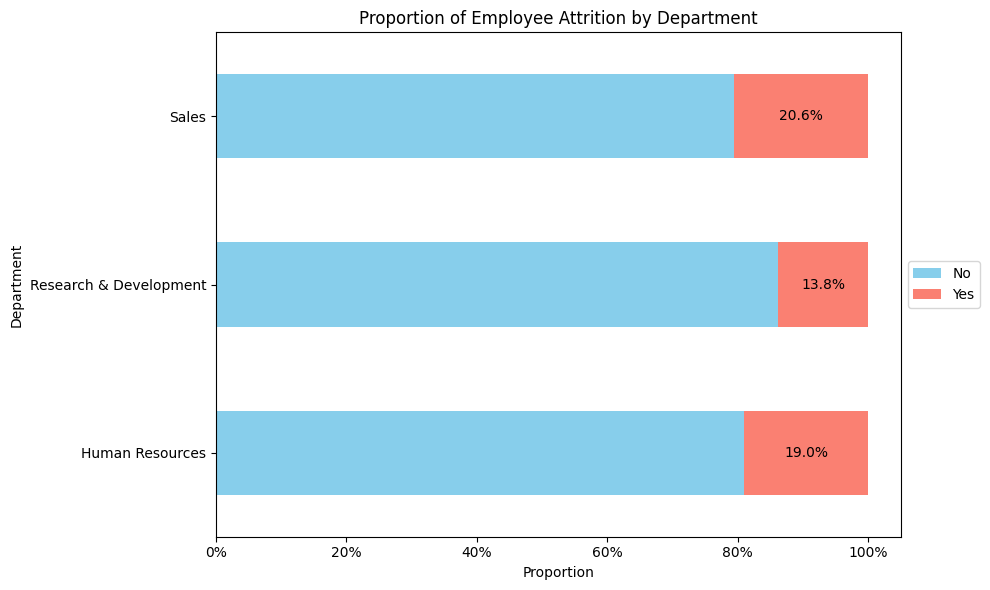

In [11]:
# Create the plot
attrition_counts = df.groupby(['Department', 'Attrition']).size().unstack(fill_value=0)
attrition_proportions = attrition_counts.div(attrition_counts.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))  # ⬅️ Wider figure to give space

attrition_proportions.plot(
    kind='barh',
    stacked=True,
    color=['skyblue', 'salmon'],
    ax=ax
)

#Set titles and labels
ax.set_title('Proportion of Employee Attrition by Department')
ax.set_xlabel('Proportion')
ax.set_ylabel('Department')

# Annotate attrition % inside the "Yes" (salmon) segment
for index, (no_val, yes_val) in enumerate(zip(attrition_proportions['No'], attrition_proportions['Yes'])):
    x_pos = no_val + yes_val / 2
    ax.text(x_pos, index, f"{yes_val:.1%}", va='center', ha='center', color='black')

#change x axis to a % scale
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Move legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # ⬅️ Push legend to the right

plt.tight_layout()  # ⬅️ Adjust layout to prevent clipping
plt.show()


This shows us that Research and Dev has the lowest attrition, but we need to check if this is statistically significant. To do this, we use a Chi-squared test to indicate if there is a significance. A p-value of <0.05 indicates a statistical significance.


In [12]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency = pd.crosstab(df["Department"], df["Attrition"])

# Run the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-squared statistic: {chi2:.3f}")
print(f"p-value: {p:.4f}")

Chi-squared statistic: 10.796
p-value: 0.0045


### Hypothesis 1 outcome: 

A p-value of 0.0045 shows that this is indeed statistically significant, and so consideration should be given (survey, focus groups?) to why working in R&D might result in greater job 'stickiness'.

Human resource and Sales have similar attrition that would warrant further investigation as to cause.

---

### Hypothesis 2 - Job stagnation leads to greater attrition

The company wishes to check if leaving people 'too long' in the same role prompts them to leave. Therefore we will look at how long our attrition group were in their final role compared to the average for the existing staff.

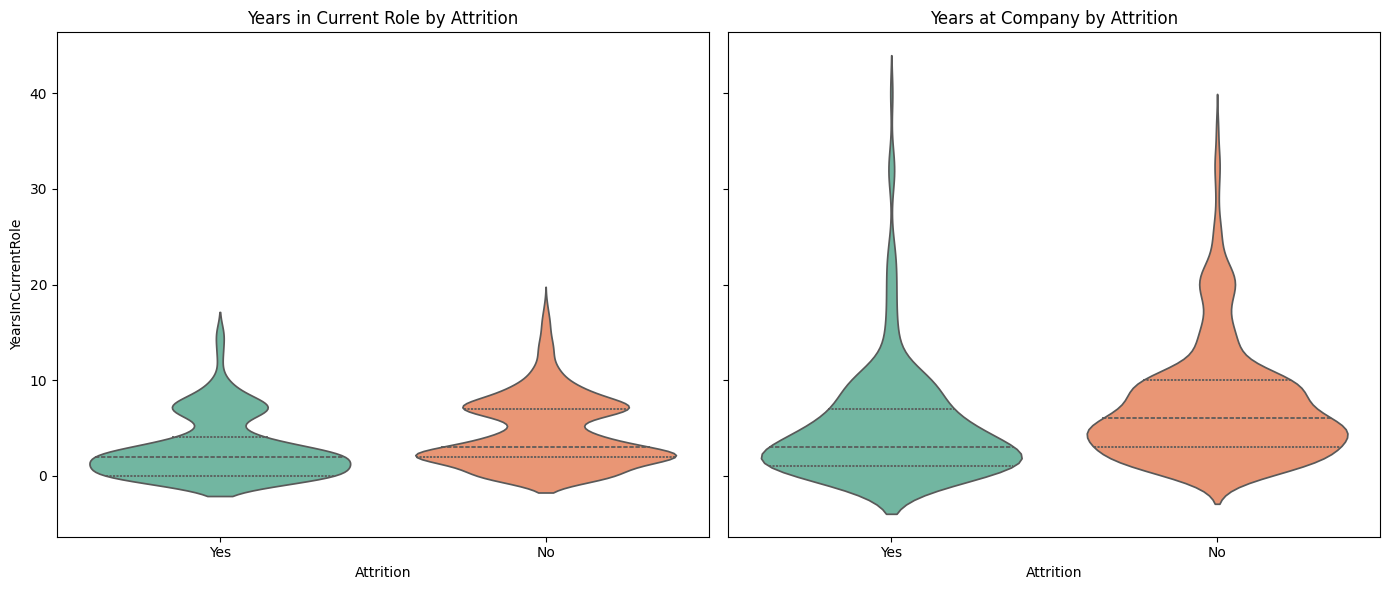

In [18]:
#side-by-side violin plots for YearsInCurrentRole and YearsAtCompany
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for YearsInCurrentRole
sns.violinplot(
    ax=axes[0],
    x="Attrition",
    y="YearsInCurrentRole",
    hue="Attrition",
    data=df,
    inner="quartile",
    palette="Set2",
    legend=False
)

axes[0].set_title("Years in Current Role by Attrition")

# Plot for YearsAtCompany
sns.violinplot(
    ax=axes[1],
    x="Attrition",
    y="YearsAtCompany",
    hue="Attrition",
    data=df,
    inner="quartile",
    palette="Set2",
    legend=False
)
axes[1].set_title("Years at Company by Attrition")

plt.tight_layout()
plt.show()

It appears that the hypothesis is false, as lower quartile, median and upper quartile values show lower time in role for the 'Attrition' group in both charts.

To test to see if this is significant, we first need to understand if this distribution follows a normal distribution curve

It should be noted that there is no indication in the data set as to whether 'retirement' is counted as attrition, but as some YearsAtCompany values are >40years, it is presumed to be included. Further analysis would need the data to separate out retirees for a more accurate retention strategy clustering.

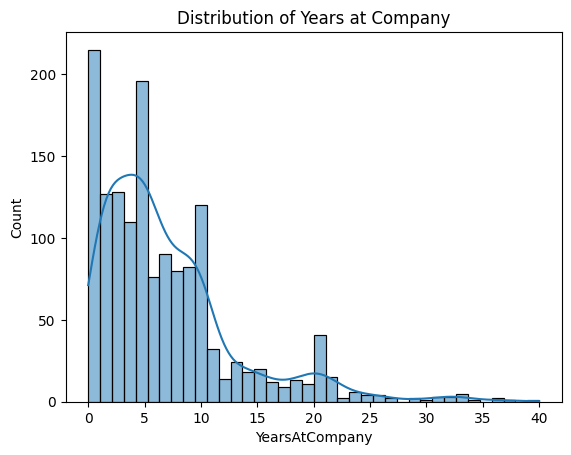

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["YearsAtCompany"], kde=True)
plt.title("Distribution of Years at Company")
plt.show()

As this is a right skewed distribution, we should do a Mann-Whitney U-test to check statistical significance. Again, a value 0.05 will indicate significance. We will test both YearsInCurentRole and YearsAtCompany.

In [24]:
#Firstly check significance with a Mann-Whitney U-test on years in role (original hypothesis)
from scipy.stats import mannwhitneyu

# Split the data into two groups
group_yes = df[df["Attrition"] == "Yes"]["YearsInCurrentRole"]
group_no = df[df["Attrition"] == "No"]["YearsInCurrentRole"]

# Run the Mann–Whitney U test
u_stat, p_val = mannwhitneyu(group_yes, group_no, alternative="two-sided")

print(f"Mann–Whitney U statistic: {u_stat:.3f}")
print(f"p-value: {p_val:.4f}")


Mann–Whitney U statistic: 105214.000
p-value: 0.0000


In [ ]:
#Secondly check significance with a Mann-Whitney U-test on years at company
from scipy.stats import mannwhitneyu

# Split the data into two groups
group_yes = df[df["Attrition"] == "Yes"]["YearsAtCompany"]
group_no = df[df["Attrition"] == "No"]["YearsAtCompany"]

# Run the Mann–Whitney U test
u_stat, p_val = mannwhitneyu(group_yes, group_no, alternative="two-sided")

print(f"Mann–Whitney U statistic: {u_stat:.3f}")
print(f"p-value: {p_val:.4f}")

Mann–Whitney U statistic: 102582.000
p-value: 0.0000


### Hypothesis 2 - outcome

The original hypothesis is rejected; long time in role is NOT a cause of attrition.

The contrary is strongly indicated; those employees with shorter tenure are at significantly greater risk than those who stay either in role or in company.

---

### Hypothesis 3 - younger employees are more likely to leave

There is a question as to whether younger employees are more likely to 'job hop' than older ones. We will look at both individual data points but also grouping employees in age brackets to help visualise. We will also split by marital status, to see if this impacts retention for each age bracket.

In [51]:
# Step 1: Create 5-year age bins using whole-number logic
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=range(20, 61, 5),  # Extend to include upper bound
    right=False,
    include_lowest=True
)

# Step 2: Calculate attrition rate per AgeGroup + MaritalStatus
grouped = (
    df.groupby(["AgeGroup", "MaritalStatus"], observed=False)
    .agg(AttritionRate=("Attrition", lambda x: (x == "Yes").mean()),
         Count=("Attrition", "count"))
    .reset_index()
)

# Step 3: Calculate average attrition rate per AgeGroup (across all marital statuses)
avg_grouped = (
    df.groupby("AgeGroup", observed=False)
    .agg(AvgAttritionRate=("Attrition", lambda x: (x == "Yes").mean()))
    .reset_index()
)

# Step 4: Format AgeGroup labels as "20–24", "25–29", etc.
grouped["AgeGroup"] = grouped["AgeGroup"].apply(lambda x: f"{int(x.left)}–{int(x.right - 1)}")
avg_grouped["AgeGroup"] = avg_grouped["AgeGroup"].apply(lambda x: f"{int(x.left)}–{int(x.right - 1)}")

# Step 5: Convert to percentage
grouped["AttritionRatePct"] = grouped["AttritionRate"] * 100
avg_grouped["AvgAttritionRatePct"] = avg_grouped["AvgAttritionRate"] * 100

# Step 6: Plot scatter
fig = px.scatter(
    grouped,
    x="AgeGroup",
    y="AttritionRatePct",
    color="MaritalStatus",
    size="Count",
    title="Attrition Rate (%) by Age Group and Marital Status",
    labels={"AttritionRatePct": "Attrition Rate (%)", "AgeGroup": "Age Group"},
    hover_data=["Count"]
)

# Step 7: Add average line
fig.add_scatter(
    x=avg_grouped["AgeGroup"],
    y=avg_grouped["AvgAttritionRatePct"],
    mode="lines+markers",
    name="Average Attrition Rate",
    line=dict(color="black", dash="dash"),
    marker=dict(size=6)
)

# Step 8: Subtitle and layout tweaks
fig.update_layout(
    title=dict(
        text="Attrition Rate (%) by Age Group and Marital Status<br><sup>Attrition rate reflects % of employees who exited within each group</sup>",
        x=0.5
    ),
    xaxis_tickangle=-45
)

fig.show()



As noted previously, there is no indication in this data set regarding retirees, and in the absence of confirmed markers, an assumption might be made that the increase in attrition in the 55-60 range could be related to retirement. Therefore we will choose to ignore that age bracket for this assessment.

It should also be noted that for all bar one age bin, single employees are more likely to leave. Whether this is due to their lower financial commitments or greater autonomy, this is something to address with qualitative research.

### Hypothesis 3 - outcome

Hypothesis 3 is proven.



---

### Hypothesis 4 - Commute distance has an impact on retention



Since remote working has been withdrawn, a question has been raised on whether we are seeing greater attrition from employees who live further away. We will look at if there is a relationship between commute and attrition, and how any factors from the previous proven hypothesis might impact it e.g. any greater or lesser sensitivty to commute for certain groups.

In [49]:
# Bin commute distances using whole-number logic
df["CommuteBin"] = pd.cut(
    df["DistanceFromHome"],
    bins=range(0, int(df["DistanceFromHome"].max()) + 5, 5),
    right=False,
    include_lowest=True
)

# Group by Attrition and CommuteBin
grouped = (
    df.groupby(["Attrition", "CommuteBin"], observed=False)
    .size()
    .reset_index(name="Count")
)

# Normalize within each Attrition group
grouped["GroupTotal"] = grouped.groupby("Attrition")["Count"].transform("sum")
grouped["PercentOfGroup"] = (grouped["Count"] / grouped["GroupTotal"]) * 100

# Sort CommuteBin by numeric order and relabel as "0–4", "5–9", etc.
bin_order = sorted(df["CommuteBin"].unique(), key=lambda x: x.left)
grouped["CommuteBin"] = pd.Categorical(grouped["CommuteBin"], categories=bin_order, ordered=True)
grouped["CommuteBin"] = grouped["CommuteBin"].apply(lambda x: f"{int(x.left)}–{int(x.right - 1)}")

# Plot
fig = px.bar(
    grouped,
    x="CommuteBin",
    y="PercentOfGroup",
    color="Attrition",
    barmode="group",
    text=grouped["PercentOfGroup"].round(1).astype(str) + "%",
    labels={"CommuteBin": "Commute Distance Bin", "PercentOfGroup": "% of Group"},
    title="Commute Distance Distribution by Attrition Status"
)

# Subtitle and layout tweaks
fig.update_layout(
    title=dict(
        text="Commute Distance Distribution by Attrition Status<br><sup>% of each group of employees by their commute distance</sup>",
        x=0.5
    ),
    xaxis_tickangle=-45
)

fig.update_traces(textposition="outside")
fig.show()


We see that up to 10 miles, the attrition is actually lower as a % of total employees. However, once commute increased to 10+ miles, all groupings show a higher attrition rate.

To test the significance, we will see use Chi-squared to test if <10 miles> has a significance

In [45]:
from scipy.stats import chi2_contingency

# Create commute category
df["CommuteCategory"] = df["DistanceFromHome"] > 10  # True = long commute

# Contingency table
contingency = pd.crosstab(df["CommuteCategory"], df["Attrition"])
chi2, p_val, _, _ = chi2_contingency(contingency)

print(f"Chi-squared test for Commute > 10 miles:")
print(f"  Chi² statistic: {chi2:.3f}")
print(f"  p-value: {p_val:.4f}")

Chi-squared test for Commute > 10 miles:
  Chi² statistic: 10.440
  p-value: 0.0012


There is indeed a statistical significant when comparing the 0-9mile commutes and the 10+ miles commutes. The company may want to therefore revisit its return-to-work mandate if it prioritises retention.

---

### Additional insight

The following graph shows attrition by job role. You will see that Sales Representative has a significantly higher attrition rate than other roles.

The subsequent graph assesses job satisfaction for roles, and there does not seem to be a visual divergence between sales rep and other roles overall. This may be something that can be identified as part of machine learning.

Otherwise, qualitative employee surveys/exit interviews should be used to address this role's likelihood and reasons for attrition.

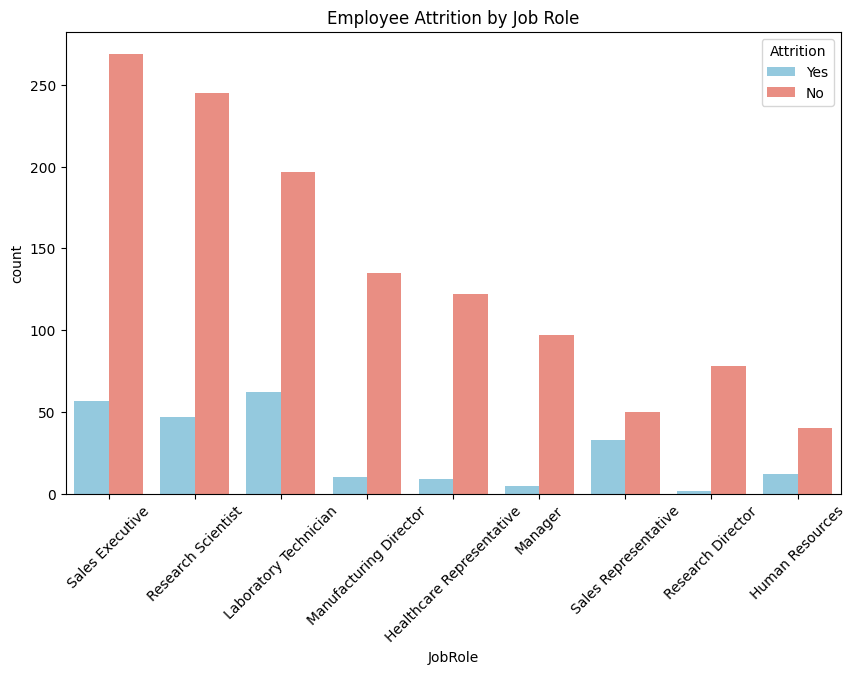

In [ ]:
#show percentage attrition per role
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='JobRole', hue='Attrition', palette=['skyblue', 'salmon'])
plt.title('Employee Attrition by Job Role')
plt.xticks(rotation=45)
plt.show()


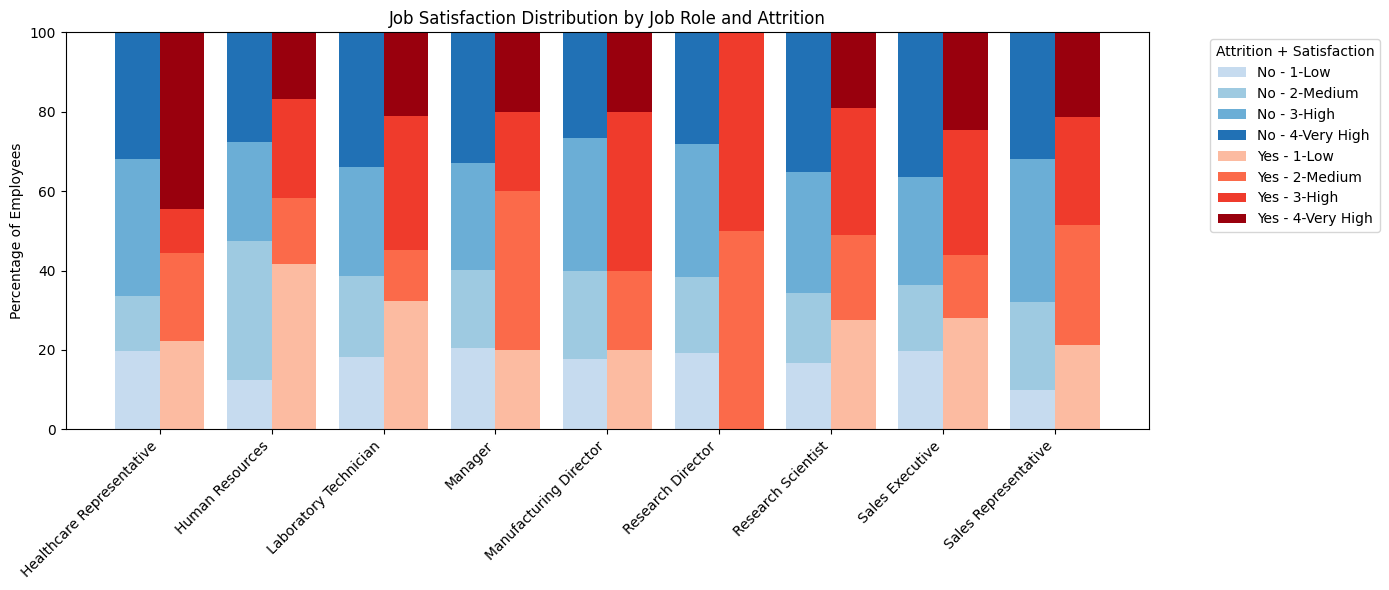

In [52]:
#plot ordinal job satisfaction levels against job roles split by attrition
# Define ordered satisfaction levels
satisfaction_levels = ['1-Low', '2-Medium', '3-High', '4-Very High']
df['JobSatisfaction'] = pd.Categorical(df['JobSatisfaction'], categories=satisfaction_levels, ordered=True)

# Group and count
grouped = (
    df.groupby(['JobRole', 'Attrition', 'JobSatisfaction'], observed=True)
    .size()
    .reset_index(name='Count')
)

# Pivot to wide format
pivot = grouped.pivot_table(
    index=['JobRole', 'Attrition'],
    columns='JobSatisfaction',
    values='Count',
    fill_value=0
)

# Normalize to percentages
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Prepare plotting structure
job_roles = pivot_pct.index.get_level_values('JobRole').unique()
attrition_colors = {'No': ['#c6dbef', '#9ecae1', '#6baed6', '#2171b5'], 'Yes': ['#fcbba1', '#fb6a4a', '#ef3b2c', '#99000d']}

fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.4
x_ticks = []
x_labels = []

for i, role in enumerate(job_roles):
    for j, attrition in enumerate(['No', 'Yes']):
        try:
            values = pivot_pct.loc[(role, attrition)]
        except KeyError:
            values = pd.Series([0] * len(satisfaction_levels), index=satisfaction_levels)
        bottom = 0
        xpos = i + (j - 0.5) * bar_width
        for k, level in enumerate(satisfaction_levels):
            ax.bar(
                xpos,
                values[level],
                bottom=bottom,
                width=bar_width,
                color=attrition_colors[attrition][k],
                label=f"{attrition} - {level}" if i == 0 else None  # only label once
            )
            bottom += values[level]
    x_ticks.append(i)
    x_labels.append(role)

# Axis and legend
ax.set_title('Job Satisfaction Distribution by Job Role and Attrition')
ax.set_ylabel('Percentage of Employees')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend(title='Attrition + Satisfaction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Next we will look at whether there is any additional insight that machine learning can provide in terms of patterns/causes for attrition. Notebook employee_attrition_ml.ipynb.